In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
npr.seed(1234)

In [4]:
def sample_gauss(n, mean, cov):
    n_dim = len(mean)
    return npr.randn(n, n_dim) * cov[None, :] + mean[None,:]

In [5]:
# data set generation
n_dim = 2
n_mean = numpy.array([0., 0.])
n_cov = numpy.array([.4, .4])
p_mean = numpy.array([1., 1.])
p_cov = numpy.array([.4, .4])

# Training examples
n_pos = 5
pos_y = numpy.ones(n_pos) 
pos_x = sample_gauss(n_pos, p_mean, 0.5 * p_cov)
n_neg = 5
neg_y = -1. * numpy.ones(n_neg)
neg_x = sample_gauss(n_neg, n_mean, 0.5 * n_cov)
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
si = npr.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

y_tra = y
x_tra = x

# Test examples
n_pos = 50
pos_y = numpy.ones(n_pos) 
pos_x = sample_gauss(n_pos, p_mean, p_cov)
n_neg = 50
neg_y = -1. * numpy.ones(n_neg)
neg_x = sample_gauss(n_neg, n_mean, n_cov)
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
si = npr.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

y_tes = y
x_tes = x



In [6]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [7]:
def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

In [8]:
def svm_dist(y, x, w, avg=False, pre=False):
    y_ = svm(x, w, pre=True)
    if pre:
        return 1. - y_ * y
    d = numpy.maximum(0., 1. - y_ * y)
    
    if not avg:
        return d
    return numpy.mean(d)

In [9]:
def cost(w, x, y, C=0.):
    return svm_dist(y, x, w, avg=True) + C * numpy.sum(w[:-1] ** 2)

svm_rule = grad(cost)

In [10]:
def _cost(w, x, y, C=0.):
    return cost(w, x, y, C), svm_rule(w, x, y, C)

In [11]:
logCs = numpy.linspace(-5, 0, 50)
Cs = numpy.concatenate([[0.], 10. ** logCs])
errors = numpy.zeros((len(Cs), 2))
ws = [None] * len(Cs)

for ii, C in enumerate(Cs):
    w0 = numpy.random.randn(n_dim+1); w0[-1] = 0.
    w = numpy.copy(w0)
    
    res = scipy.optimize.minimize(_cost, w0, (x_tra, y_tra, C), method='L-BFGS-B', jac=True)
    w = res.x

    tra_er = numpy.sum(numpy.abs(svm(x_tra, w) - y_tra)) / numpy.float(len(y_tra))
    tes_er = numpy.sum(numpy.abs(svm(x_tes, w) - y_tes)) / numpy.float(len(y_tes))
    
    errors[ii, :] = [tra_er, tes_er]
    ws[ii] = w

<IPython.core.display.Javascript object>


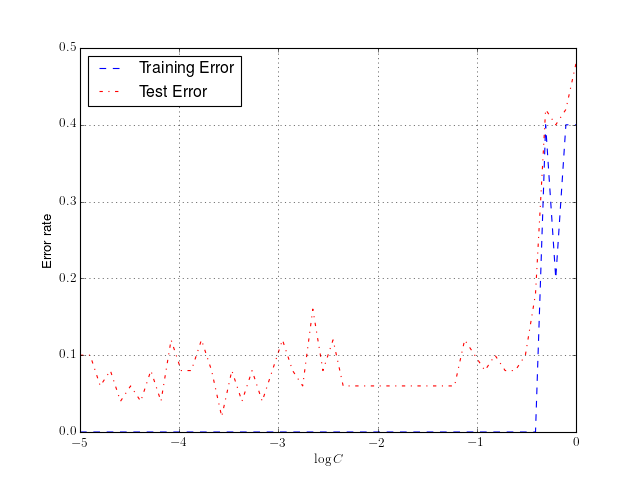

In [12]:
plot.figure()

plot.hold('on')
plot.plot(logCs, errors[1:,0], 'b--')
plot.plot(logCs, errors[1:,1], 'r-.')
plot.hold('off')

plot.legend(['Training Error', 'Test Error'], loc='best')
plot.xlabel('\log C')
plot.ylabel('Error rate')
plot.grid('on')

plot.show()

In [13]:
plot.savefig('../figures/overfit1.pdf', dpi=100)

In [14]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == -1 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [15]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


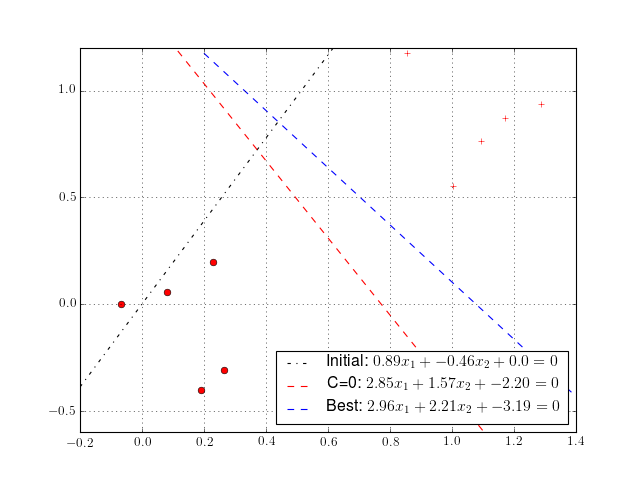

<IPython.core.display.Javascript object>


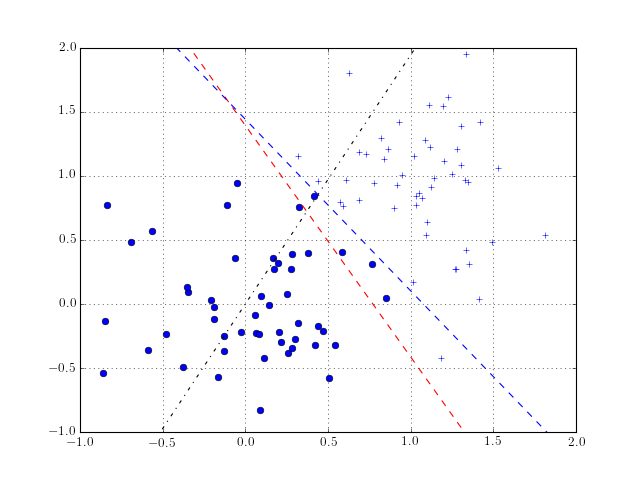

In [17]:
plot.figure()

vis_data(x_tra, y_tra, c='r')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(ws[0], 'r--')
plt2 = vis_hyperplane(ws[numpy.argmin(errors[:,1])], 'b--')
plot.legend([plt0, plt1, plt2], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'C=0: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(ws[0])),
        'Best: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(ws[numpy.argmin(errors[:,1])]))],
           loc='best')

plot.show()
plot.savefig('../figures/overfit2_tra.pdf', dpi=100)

plot.figure()
vis_data(x_tes, y_tes, c='b')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(ws[0], 'r--')
plt2 = vis_hyperplane(ws[numpy.argmin(errors[:,1])], 'b--')

plot.show()
plot.savefig('../figures/overfit2_tes.pdf', dpi=100)
